In [1]:
import numpy as np
from osgeo import gdal
from PIL import Image

from d22_utils import get_extent, get_query_bbox, add_colorbar, print_info

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib import gridspec

from copy import deepcopy

In [2]:
# Load query bounding box
query_bbox = get_query_bbox("bolzano.geojson")

In [3]:
# Select data
data_type = 'L1' # 'L1 or L2'
warped = False

if data_type == 'L2':
    if warped:
        filepaths = ["results_warped/EURAC_min-evi_4326.tif", "results_warped/VITO_min-evi_4326.tif", "results/WWU_GEE_min-evi.png"]
    else:
        filepaths = ["results/EURAC_min-evi.tif", "results/VITO_min-evi.tif", "results/WWU_GEE_min-evi.png"]
elif data_type == 'L1':
    if warped:
        filepaths = ["results_warped/EODC_min-evi_L1C_4326.tif", "results_warped/VITO_min-evi_L1C_4326.tif"]
    else:
        filepaths = ["results/EODC_min-evi_L1C_S2A.tif", "results/VITO_min-evi_L1C.tif", "results/sinergise_min-evi_L1C.tif"]

In [4]:
# Load data
rasters = {}
for k, item in enumerate(filepaths):
    item_name = item.split('/')[-1].split('_')[0]
    if item_name == "WWU":
        item_name = "WWU-GEE"
        rasters[item_name] = {
        'ds': None,
        'data': np.asarray(Image.open(item)).astype(np.float64)
    }
    else:
        rasters[item_name] = {
            'ds': gdal.Open(item),
            'data': gdal.Open(item).ReadAsArray().astype(np.float64)
        }
    if not isinstance(rasters[item_name]['data'], np.float64):
        rasters[item_name]['data'] = rasters[item_name]['data'].astype(np.float64)
    print(item_name)

EODC
VITO
sinergise


In [5]:
# Print some info about raster data
for item in rasters:
    print(item)
    print_info((rasters[item]['data']))

EODC
Raster shape: (678, 961)
Min: -inf
Mean: -inf
Max: 38.842
Negative values [%]: 98.4 %
Negative values (<-1000) [%]: 0.6 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


VITO
Raster shape: (988, 1488)
Min: -12612.941
Mean: 0.335
Max: 0.89
Negative values [%]: 2.3 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


sinergise
Raster shape: (678, 961)
Min: -3054.765
Mean: 0.057
Max: 0.41
Negative values [%]: 2.5 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %




-inf 38.842445373535156
1
11
-12612.94140625 0.8898524045944214
0
220
-3054.7646484375 0.4098169803619385
0
121


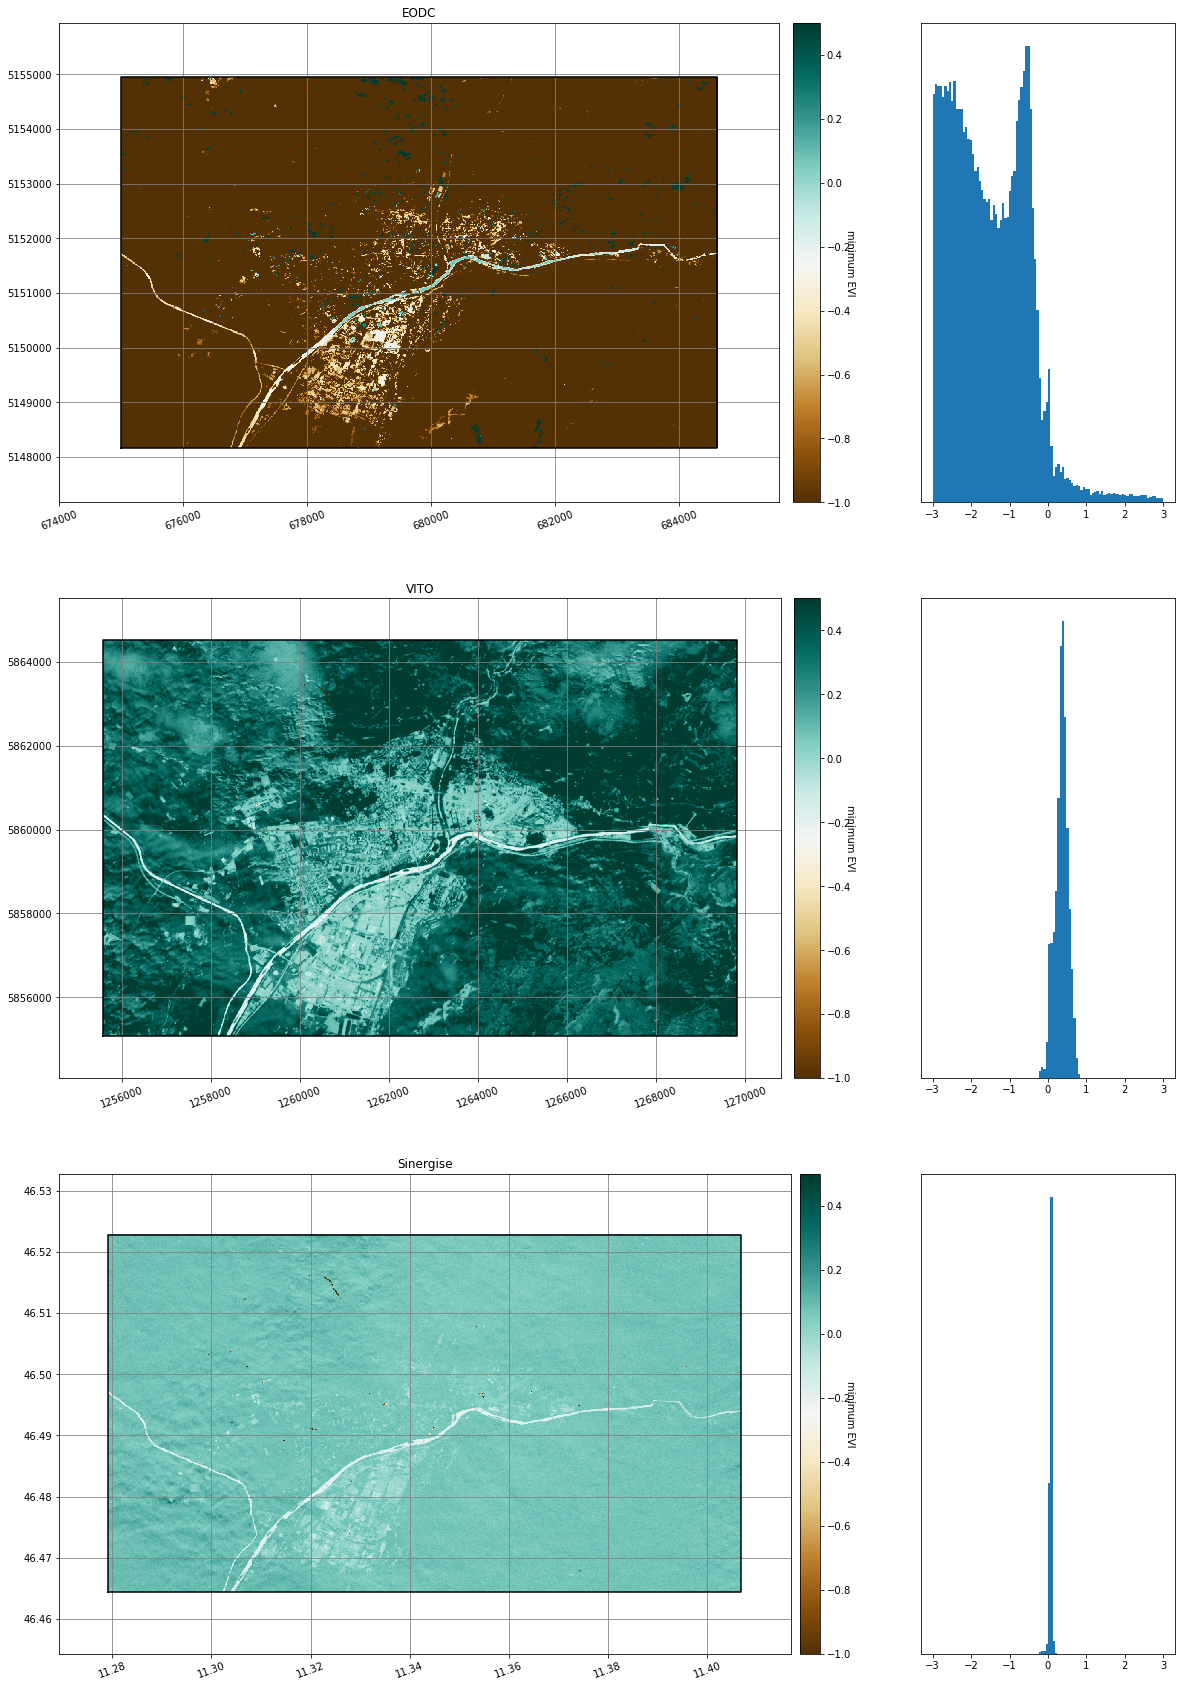

In [6]:
# Make plot

# create colormap
current_cmap = plt.get_cmap("BrBG")
current_cmap.set_bad(color=[0.85, 0.85, 0.85])


fig = plt.figure(figsize=(20, 10*len(rasters)))
gs = gridspec.GridSpec(len(rasters), 2, width_ratios=[3, 1])
gs.update(wspace=0.2, hspace=0.2)
for k, item in enumerate(rasters):
    ## Create axis for subplot ##
    j = k+k     
    ax1 = plt.subplot(gs[j+1])
    ax2 = plt.subplot(gs[j])
    
    item0 = deepcopy(rasters[item]['data'])
    print(np.min(item0), np.max(item0))
    print(np.sum(np.isinf(item0)))
    item0[item0==0] = np.nan
    item0[np.isinf(item0)] = np.nan
    print(np.sum(np.isnan(item0)))
    
    
    ## Plot map ##
    ## Plot normalized histogram ##
    if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
        hist_range = (-3, 3)
    else:
        hist_range = (0, 255)
    N = item0.shape[0] * item0.shape[1]
    tmp_data = item0.reshape(1, N).flatten()
    tmp_data[tmp_data == -np.inf] = -9999
    tmp_data[np.isnan(tmp_data)] = -9999
    im = ax1.hist(tmp_data, bins=100, range=hist_range, density=True)
    ax1.get_yaxis().set_ticks([]) # no y ticks
    
    ## Plot map ##
    subplot_title = item.replace('sinergise', 'Sinergise')
    ax2.set_title(subplot_title)
    #if k==0:
    #    v_min = -1
    #    v_max = 0.5
    #elif k==1:
    #    v_min = -1
    #    v_max = 0.5
    v_min = -1
    v_max = 0.5
    if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
        if item == 'sinergise':
            raster_extent, raster_bbox = get_extent(rasters[item]['ds'], geographic=True)
            offset = 0.01 # degrees
        else:
            raster_extent, raster_bbox = get_extent(rasters[item]['ds'])
            offset = 1000 # meters
        im = ax2.imshow(item0, cmap=current_cmap, vmin=v_min, vmax=v_max, aspect='auto', extent=raster_extent)
        plt.xticks(rotation=20)

        ## Add bounding boxes ##
        ax2.plot(raster_bbox[0], raster_bbox[1], 'k') # raster bbox
        if warped:
            ax2.plot(query_bbox[0], query_bbox[1], 'r') # query bbox

        # Add grid lines
        ax2.grid(b=True, which='major', color='gray', linestyle='-')
        
        # Make axis slightly larger
        ax2.set_xlim(raster_extent[0]-offset, raster_extent[1]+offset)
        ax2.set_ylim(raster_extent[2]-offset, raster_extent[3]+offset)
    else:
        im = ax2.imshow(item0, cmap=current_cmap, aspect='auto')

    im = add_colorbar(im)
    
    del(item0, ax1, ax2)
    
 
fig.savefig(f'comparison_output/comparison_min-evi_{data_type}.png', bbox_inches='tight')

In [7]:
from utils import geo_math

In [9]:
print(geo_math.meter2deg(0.000132899130544, 0, inverse=True))
print(geo_math.meter2deg(0.000086106034488, 46, inverse=True))

14.794263655100053
13.798552491785468
